<H1>Importing Libraries</H1>

In [20]:
import urllib3.request
import csv
import codecs
import pandas as pd
from geopy.geocoders import Nominatim
import math
import os
import folium
import numpy as np
import time
import requests
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

<H1>Scraping Data</H1>

In [21]:
city_data = pd.DataFrame(columns=["neighborhood","latitude", "longitude"])

with codecs.open("neighbourhoods.csv", "r", "utf-8") as districts_file:
    districts_reader = csv.reader(districts_file)
    for row in districts_reader:
        district = row[0]
        neighborhoods = [x.strip() for x in row[1].split(',')]
        for neigh in neighborhoods:
            city_data = city_data.append(
            
            {
                "neighborhood" : "{},{}".format(district,neigh)
            },
                ignore_index = True
            
            )

In [22]:
print(city_data.shape)
city_data.head()

(68, 3)


,neighborhood,latitude,longitude
0,"Arganzuela,Acacias",NaN,NaN
1,"Arganzuela,Atocha",NaN,NaN
2,"Arganzuela,Chopera",NaN,NaN
3,"Arganzuela,Delicias",NaN,NaN
4,"Arganzuela,Imperial",NaN,NaN


<H3>Neighborhood Geolocation </H3>

In [23]:
geolocator = Nominatim()

country = "Spain"
city = "Madrid"

geocode_filename = "neighbourhoods-geocode.csv" 

# if file exists
if os.path.isfile(geocode_filename):
    with codecs.open(geocode_filename, "r", "utf-8") as geocode_file:
        geocode_reader = csv.reader(geocode_file, delimiter=";")
        for row in geocode_reader:
            latitude = row[0]
            longitude = row[1]
            neighborhood = row[2]
            city_data.loc[city_data['neighborhood'] == neighborhood, 'latitude'] = float(latitude)
            city_data.loc[city_data['neighborhood'] == neighborhood, 'longitude'] = float(longitude)
    

with codecs.open(geocode_filename, "a", "utf-8") as geocode_file:
    for index, row in city_data.iterrows():
        latitude = float(row['latitude'])
        longitude = float(row['longitude'])
        
        if math.isnan(latitude) == True | math.isnan(longitude) == True:
            neighborhood = row['neighborhood']
            address = "{},{},{}".format(neighborhood, city, country)
            retries = 3
            while (retries > 0):
                try:
                    location = geolocator.geocode(address)
                    latitude = location.latitude
                    longitude = location.longitude
                    print("{} : ({},{})".format(address, latitude, longitude))
                    city_data.loc[index, 'latitude'] = float(latitude)
                    city_data.loc[index, 'longitude'] = float(longitude)
                    geocode_file.write("{};{};{}\n".format(latitude, longitude, neighborhood))
                    retries = 0
                except:
                    print("ERROR: ", address)
                    retries = retries - 1
                    time.sleep(1)

Arganzuela,Acacias,Madrid,Spain : (40.3975231,-3.709052)
Arganzuela,Atocha,Madrid,Spain : (40.3934913,-3.70024025834118)
Arganzuela,Chopera,Madrid,Spain : (40.392827,-3.69931317432463)
Arganzuela,Delicias,Madrid,Spain : (40.39803445,-3.69381878647137)
Arganzuela,Imperial,Madrid,Spain : (40.3974099,-3.7090155)
Arganzuela,Legazpi,Madrid,Spain : (40.3929772,-3.688445)
Arganzuela,Palos de Moguer,Madrid,Spain : (40.4006138,-3.6960556)
Barajas,Aeropuerto,Madrid,Spain : (40.4530677,-3.5809324)
Centro,Cortes,Madrid,Spain : (40.4143476,-3.69852518277385)
Centro,Embajadores,Madrid,Spain : (40.40968055,-3.70164442641322)
Centro,Justicia,Madrid,Spain : (40.4239569,-3.69574732085505)
Centro,Palacio,Madrid,Spain : (40.41512925,-3.71561799839909)
Centro,Sol,Madrid,Spain : (40.4168968,-3.70448454994211)
Centro,Universidad,Madrid,Spain : (40.4252644,-3.70660596905568)
Chamberí,Almagro,Madrid,Spain : (40.43334905,-3.69558223305878)
Chamberí,Arapiles,Madrid,Spain : (40.43480145,-3.70929497548883)
Chamber

In [24]:
print(city_data.shape)
city_data.head()

(68, 3)


,neighborhood,latitude,longitude
0,"Arganzuela,Acacias",40.3975,-3.70905
1,"Arganzuela,Atocha",40.3935,-3.70024
2,"Arganzuela,Chopera",40.3928,-3.69931
3,"Arganzuela,Delicias",40.398,-3.69382
4,"Arganzuela,Imperial",40.3974,-3.70902


In [25]:
city = "Madrid"
location = geolocator.geocode(city)
city_latitude = location.latitude
city_longitude = location.longitude
city_map = folium.Map(location=[city_latitude, city_longitude], zoom_start=11)
for lat, lng, neighborhood in zip(city_data['latitude'], city_data['longitude'], city_data['neighborhood']):
    if math.isnan(lat) == False & math.isnan(lng) == False:
        label_txt = "{}, {}".format(neighborhood, city)
        label = folium.Popup(label_txt, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7).add_to(city_map) 

city_map

<H1>Obtaining Venues</H1>

In [26]:
CLIENT_ID = 'DGQEGGLRZWBUTCT4CMH1VLY2DTSBKLIQJWM0MZDHAP3X1PK4' # your Foursquare ID
CLIENT_SECRET = '23HBEBCJGDDPPHSBHCOVV2O2LQYEINOKSAAVQOCCBWPJIYRU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DGQEGGLRZWBUTCT4CMH1VLY2DTSBKLIQJWM0MZDHAP3X1PK4
CLIENT_SECRET:23HBEBCJGDDPPHSBHCOVV2O2LQYEINOKSAAVQOCCBWPJIYRU


In [27]:
def getNearbyVenues(names, latitudes, longitudes, radius=800, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        try:
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']
        
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])

        except:
            print("ERROR: ", url)

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['neighborhood', 
                  'neighborhood_latitude', 
                  'neighborhood_longitude', 
                  'venue', 
                  'venue_latitude', 
                  'venue_longitude', 
                  'venue_category']
    
    return(nearby_venues)

In [28]:
venues_filename = "madrid-district-neighborhoods-venues.csv"

if os.path.isfile(venues_filename):
    with codecs.open(venues_filename, "r", "utf-8") as venues_file:
        venues_reader = csv.reader(venues_file, delimiter=";")        
        venues_list = []        
        for row in venues_reader:
            venues_list.append([( row[0], row[1], row[2], row[3], row[4], row[5], row[6])])
            
        city_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        city_venues.columns = [ 'neighborhood_latitude', 'neighborhood_longitude', 'neighborhood',
                  'venue', 'venue_latitude', 'venue_longitude', 'venue_category']

else:
    city_venues = getNearbyVenues(
                              names=city_data['neighborhood'],
                              latitudes=city_data['latitude'],
                              longitudes=city_data['longitude']
                              
                              )

    with codecs.open(venues_filename, "w", "utf-8") as venues_file:
        for index, row in city_venues.iterrows():
            neighborhood = row['neighborhood']
            neighborhood_latitude = row['neighborhood_latitude']
            neighborhood_longitude = row['neighborhood_longitude']
            venue = row['venue']
            venue_latitude = row['venue_latitude']
            venue_longitude = row['venue_longitude']
            venue_category = row['venue_category']
            venues_file.write("{};{};{};{};{};{};{}\n"
                              .format(neighborhood, neighborhood_latitude, neighborhood_longitude,
                                      venue, venue_latitude, venue_longitude, venue_category))
   

    


In [29]:
print("shape {}".format(city_venues.shape))
city_venues.head()


shape (4474, 7)


,neighborhood,neighborhood_latitude,neighborhood_longitude,venue,venue_latitude,venue_longitude,venue_category
0,"Arganzuela,Acacias",40.397523,-3.709052,La Gelateria di Angelo,40.397951,-3.707739,Ice Cream Shop
1,"Arganzuela,Acacias",40.397523,-3.709052,Parque de la Arganzuela,40.398330,-3.708686,Park
2,"Arganzuela,Acacias",40.397523,-3.709052,Puente Monumental del Parque de la Arganzuela,40.397671,-3.711777,Bridge
3,"Arganzuela,Acacias",40.397523,-3.709052,Toboganes Parque de la Arganzuela,40.398026,-3.710241,Playground
4,"Arganzuela,Acacias",40.397523,-3.709052,Madrid Río (Sector Central),40.396744,-3.712842,Park


In [30]:
print('{} uniques categories'.format(len(city_venues['venue_category'].unique())))

245 uniques categories


<H3>Neighborhood Segmentation</H3>

In [12]:
dummy_df = pd.get_dummies(city_venues[['venue_category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe and move column to the first column
dummy_df['neighborhood'] = city_venues['neighborhood'] 
col_index = dummy_df.columns.tolist().index('neighborhood')
col_order = [dummy_df.columns[col_index]] \
                + list(dummy_df.columns[0:col_index]) \
                + list(dummy_df.columns[col_index+1:])
dummy_df = dummy_df[col_order]
print(dummy_df.shape)
dummy_df.head()

(4798, 250)


,neighborhood,Accessories Store,African Restaurant,Airport Terminal,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Trade School,Trail,Train,Train Station,Travel Lounge,Used Bookstore,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,-3.709052,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-3.709052,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-3.709052,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-3.709052,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-3.709052,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
city_grouped = dummy_df.groupby('neighborhood').mean().reset_index()
print(city_grouped.shape)
city_grouped.head()

(68, 250)


,neighborhood,Accessories Store,African Restaurant,Airport Terminal,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Trade School,Trail,Train,Train Station,Travel Lounge,Used Bookstore,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,-3.5809324,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-3.6088938,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-3.6106117,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-3.614806,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-3.615954,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
Y = city_grouped.drop('neighborhood', 1)
print(Y.shape)
Y.head()

(68, 249)


,Accessories Store,African Restaurant,Airport Terminal,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Trade School,Trail,Train,Train Station,Travel Lounge,Used Bookstore,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


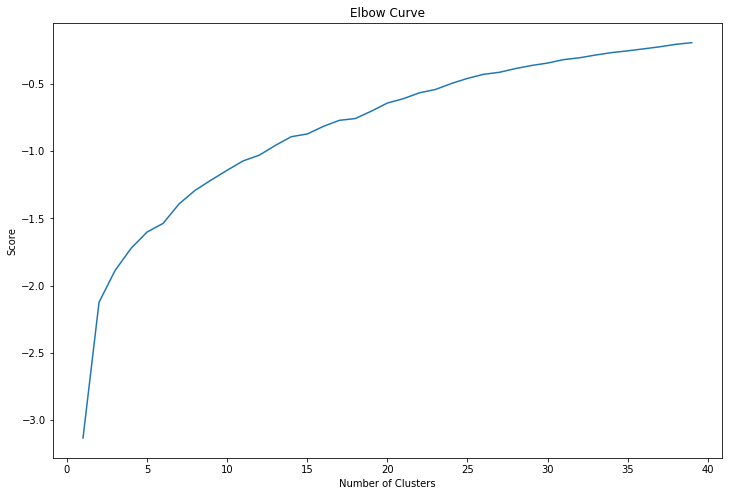

In [33]:
Nc = range(1, 40)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(Y).score(Y) for i in range(len(kmeans))]

plt.figure(1, figsize=(12, 8))
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [34]:
# set number of clusters
kclusters = 10
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Y)
# check cluster labels generated for each row in the dataframe
print(len(kmeans.labels_))
kmeans.labels_

68


array([5, 8, 8, 7, 7, 8, 9, 9, 5, 2, 6, 6, 8, 6, 0, 0, 5, 5, 8, 0, 0, 2,
       0, 2, 2, 8, 2, 8, 2, 2, 5, 4, 8, 5, 5, 0, 8, 4, 8, 5, 5, 8, 0, 5,
       5, 8, 8, 4, 8, 2, 5, 5, 8, 2, 8, 2, 8, 2, 2, 2, 3, 8, 2, 2, 1, 9,
       8, 8], dtype=int32)

In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [36]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
colnames = ['neighborhood']
for ind in np.arange(num_top_venues):
    try:
        colnames.append('{}{}'.format(ind+1, indicators[ind]))
    except:
        colnames.append('{}th'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=colnames)
neighborhoods_venues_sorted['neighborhood'] = city_grouped['neighborhood']

for ind in np.arange(city_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(city_grouped.iloc[ind, :], num_top_venues)

print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()

(68, 11)


,neighborhood,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
0,-3.5809324,Hotel,Tapas Restaurant,Airport Terminal,Restaurant,Hotel Bar,Gym,Spanish Restaurant,Pizza Place,Clothing Store,Grocery Store
1,-3.6088938,Grocery Store,Spanish Restaurant,Pizza Place,Park,Fast Food Restaurant,Pool,Beer Bar,Sandwich Place,Breakfast Spot,Café
2,-3.6106117,Park,Chinese Restaurant,Asian Restaurant,Restaurant,Pizza Place,Soccer Field,Tapas Restaurant,Metro Station,Spanish Restaurant,Bar
3,-3.614806,Gym,Park,Supermarket,Café,Fast Food Restaurant,Sandwich Place,Pet Store,Shopping Mall,Pizza Place,Music Venue
4,-3.615954,Music Venue,Asian Restaurant,Shopping Mall,Supermarket,Park,Gym,Metro Station,Pizza Place,Donut Shop,Flea Market


In [37]:
city_merged = city_data
print(city_merged.shape)
# add clustering labels
city_merged['cluster-label'] = kmeans.labels_

#city_merged.apply(lambda col: col.drop_duplicates().reset_index(drop=True))
# merge city_grouped with city_data to add latitude/longitude for each neighborhood
city_merged = city_merged.join(city_grouped.set_index('neighborhood'), on='neighborhood')

print(city_merged.shape)
city_merged.head()

(68, 3)
(68, 253)


,neighborhood,latitude,longitude,cluster-label,Accessories Store,African Restaurant,Airport Terminal,American Restaurant,Arcade,Arepa Restaurant,...,Trade School,Trail,Train,Train Station,Travel Lounge,Used Bookstore,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,"Arganzuela,Acacias",40.3975,-3.70905,5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Arganzuela,Atocha",40.3935,-3.70024,8,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Arganzuela,Chopera",40.3928,-3.69931,8,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Arganzuela,Delicias",40.398,-3.69382,7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Arganzuela,Imperial",40.3974,-3.70902,7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<H3>Segments Analysis</H3>

In [38]:
# create map
city = "Madrid"
location = geolocator.geocode(city)
city_latitude = location.latitude
city_longitude = location.longitude
map_clusters = folium.Map(location=[city_latitude, city_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_merged['latitude'], city_merged['longitude'], \
                                  city_merged['neighborhood'], city_merged['cluster-label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [40]:
def print_cluster_info(cluster_number):
    #print("Cluster {} - Size {}".format(cluster_number+1, len(city_merged[city_merged['cluster-label'] == cluster_number])))
    cluster_data = city_merged.loc[city_merged['cluster-label'] == cluster_number,city_merged.columns[[0]+list(range(4,city_merged.shape[1]))]]
    #cluster_venues_list = []
    #for idx, row in cluster_data.iterrows():
    #    for i in range(1,row.shape[0]):
    #        cluster_venues_list.append(row[i])
    #cluster_venues = pd.DataFrame(cluster_venues_list, columns=['venue'])    
    #cluster_venues = cluster_venues.groupby('venue').venue.agg('count').to_frame('count').reset_index()
    #cluster_venues.sort_values(by=['count','venue'], ascending=False, inplace=True)
    #print(cluster_venues.head(10))
    return cluster_data

<H3>Cluster 1</H3>

In [41]:
print_cluster_info(0)

,neighborhood,Accessories Store,African Restaurant,Airport Terminal,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Trade School,Trail,Train,Train Station,Travel Lounge,Used Bookstore,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop,Yoga Studio
14,"Chamberí,Almagro",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,"Chamberí,Arapiles",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,"Chamberí,Vallehermoso",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,"Ciudad Lineal,Atalaya",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,"Ciudad Lineal,Concepción",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,"Moratalaz,Media Legua",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,"Retiro,Estrella",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<H3>Cluster 2</H3>

In [42]:
print_cluster_info(1)

,neighborhood,Accessories Store,African Restaurant,Airport Terminal,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Trade School,Trail,Train,Train Station,Travel Lounge,Used Bookstore,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop,Yoga Studio
64,"Villaverde,Butarque",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<H3>Cluster 3</H3>

In [43]:
print_cluster_info(2)

,neighborhood,Accessories Store,African Restaurant,Airport Terminal,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Trade School,Trail,Train,Train Station,Travel Lounge,Used Bookstore,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop,Yoga Studio
9,"Centro,Embajadores",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,"Ciudad Lineal,Colina",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,"Ciudad Lineal,Pueblo Nuevo",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,"Ciudad Lineal,Quintana",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,"Fuencarral - El Pardo,El Pardo",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,"Latina,Aguilas",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,"Latina,Aluche",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,"Salamanca,Goya",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,"San Blas - Canillejas,Canillejas",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,"San Blas - Canillejas,Rosas",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<H3>Cluster 4</H3>

In [44]:
print_cluster_info(3)

,neighborhood,Accessories Store,African Restaurant,Airport Terminal,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Trade School,Trail,Train,Train Station,Travel Lounge,Used Bookstore,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop,Yoga Studio
60,"Usera,Almendrales",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<H3>Cluster 5</H3>


In [46]:
print_cluster_info(4)

,neighborhood,Accessories Store,African Restaurant,Airport Terminal,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Trade School,Trail,Train,Train Station,Travel Lounge,Used Bookstore,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop,Yoga Studio
31,"Moncloa - Aravaca,Aravaca",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,"Moratalaz,Vinateros",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,"Salamanca,Castellana",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<H3>Cluster 6</H3>

In [48]:
print_cluster_info(5)

,neighborhood,Accessories Store,African Restaurant,Airport Terminal,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Trade School,Trail,Train,Train Station,Travel Lounge,Used Bookstore,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,"Arganzuela,Acacias",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,"Centro,Cortes",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,"Chamberí,Gaztambide",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,"Chamberí,Rios Rosas",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,"Latina,Campamento",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,"Moratalaz,Horcajo",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,"Moratalaz,Marroquina",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,"Puente de Vallecas,Palomeras Bajas",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,"Puente de Vallecas,San Diego",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,"Retiro,Ibiza",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<H3>Cluster 7</H3>

In [49]:
print_cluster_info(6)

,neighborhood,Accessories Store,African Restaurant,Airport Terminal,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Trade School,Trail,Train,Train Station,Travel Lounge,Used Bookstore,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop,Yoga Studio
10,"Centro,Justicia",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,"Centro,Palacio",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,"Centro,Universidad",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<H3>Cluster 8</H3>

In [50]:
print_cluster_info(7)

,neighborhood,Accessories Store,African Restaurant,Airport Terminal,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Trade School,Trail,Train,Train Station,Travel Lounge,Used Bookstore,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop,Yoga Studio
3,"Arganzuela,Delicias",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Arganzuela,Imperial",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<H3>Cluster 9</H3>

In [51]:
print_cluster_info(8)

,neighborhood,Accessories Store,African Restaurant,Airport Terminal,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Trade School,Trail,Train,Train Station,Travel Lounge,Used Bookstore,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop,Yoga Studio
1,"Arganzuela,Atocha",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Arganzuela,Chopera",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"Arganzuela,Legazpi",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,"Centro,Sol",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,"Chamberí,Trafalgar",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,"Ciudad Lineal,Ventas",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,"Fuencarral - El Pardo,Mirasierra",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,"Moratalaz,Fontarrón",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,"Moratalaz,Pavones",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,"Puente de Vallecas,Numancia",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<H3>Cluster 10</H3>

In [52]:
print_cluster_info(9)

,neighborhood,Accessories Store,African Restaurant,Airport Terminal,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Trade School,Trail,Train,Train Station,Travel Lounge,Used Bookstore,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop,Yoga Studio
6,"Arganzuela,Palos de Moguer",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,"Barajas,Aeropuerto",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,"Villaverde,Los Angeles",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
